#              Predicting the alpha signal using microblogging data

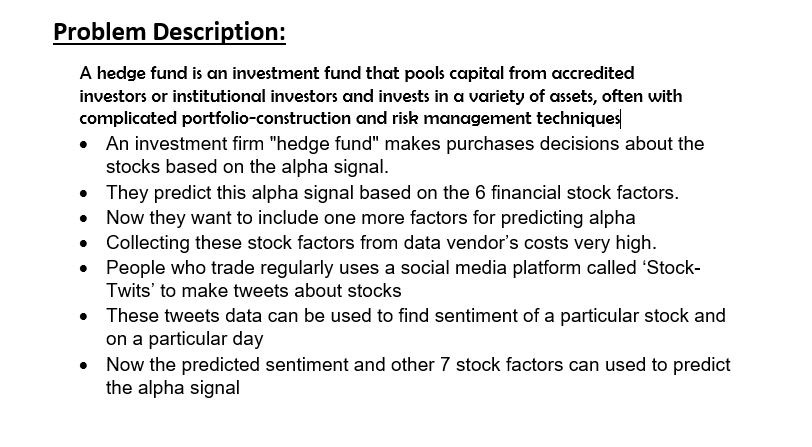

In [3]:
from IPython.display import Image
Image("Prob_stat.jpg")

### Importing Libraries

In [67]:
import json
import os
import pandas as pd
import re
import numpy as np

from IPython.display import Image
import datetime  #datetime

#nlp
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.tokenize import word_tokenize
import emoji

# Importing stop words from NLTK coupus and word tokenizer
from nltk.corpus import stopwords

# Plots
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Train test split
from sklearn.model_selection import train_test_split

#Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

#Models
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score,confusion_matrix,f1_score
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

#Impute
from sklearn.preprocessing import Imputer
from missingpy import KNNImputer
from sklearn.impute import SimpleImputer

#Pre-processing 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Tuning or grid search
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Learning Curve
from sklearn.model_selection import learning_curve

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
os.getcwd()

'D:\\Tejdeep\\Data Science\\PHD\\Code'

### Loading the JSON file

In [6]:
# Read the text data from JSON format
json_data = pd.read_json("train_data-1573118738755.json")

In [7]:
json_data.head()
# column values that are nested and not entirely usable at this point.

,records
0,{'stocktwit_tweet': '$AMD going up but hesitat...
1,{'stocktwit_tweet': '@inforlong @MariaGascon D...
2,"{'stocktwit_tweet': '$AVGO WTF?', 'sentiment_s..."
3,{'stocktwit_tweet': '$PH New Insider Filing O...
4,{'stocktwit_tweet': '$FB if it bounces tommorr...


In [8]:
tweets_data = pd.DataFrame([md for md in json_data.records])
tweets_data.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


### Taking a Copy of original data

In [9]:
import copy
original_tweets_data = copy.deepcopy(tweets_data)
print(tweets_data.keys())
print(original_tweets_data.keys())    

Index(['sentiment_score', 'stocktwit_tweet', 'ticker', 'timestamp'], dtype='object')
Index(['sentiment_score', 'stocktwit_tweet', 'ticker', 'timestamp'], dtype='object')


### Retrieving date from timestamp

In [10]:
tweets_data['timestamp'] = tweets_data['timestamp'] .str.split(' ').str[0]

In [11]:
tweets_data.head()

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09
2,2,$AVGO WTF?,$AVGO,2018-07-12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23


### Removing duplicate records

In [12]:
print("Length before duplicates",len(tweets_data))
tweets_data.drop_duplicates(keep = False, inplace = True) 
print("Length before duplicates",len(tweets_data))

Length before duplicates 1039131
Length before duplicates 995819


## Pre-processing

In [13]:
# Importing HTMLParser
# HTML tags are typically one of these components which don’t add much value towards understanding and analyzing text.
# Convert all named and numeric character references (e.g. &gt;, &#62;, &#x3e;) in the string s to the corresponding Unicode characters
from html.parser import HTMLParser
html_parser = HTMLParser()

In [14]:
# Created a new columns i.e. clean_tweet contains the same tweets but cleaned version
tweets_data['clean_tweet'] = tweets_data['stocktwit_tweet'].apply(lambda x: html_parser.unescape(x))
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,$AMD going up but hesitating however chart is ...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,@inforlong @MariaGascon Despite\nChina trade w...
2,2,$AVGO WTF?,$AVGO,2018-07-12,$AVGO WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,$PH\n New Insider Filing On: \n MULLER KLAUS P...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,$FB if it bounces tommorrow do the right thing...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,$FB as usual......RED \nevery day.
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,$AET UnitedHealth Group Goes Ex-Dividend Today...
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,$NOC let's see when we can hit 310
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,@InCyD3R @Ferrabi I bet you’re also the one sa...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,$AMD Pastor the Stooge


### Removing "@user" from all the tweets

In [15]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [16]:
# remove twitter handles (@user)
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: remove_pattern(x,"@[\w]*"))

### Removing "$ticker" from all the tweets

In [17]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: re.sub("\$[\w]*","",x))

### Removing "URL's" from all the tweets

In [18]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: re.sub('http\S*|www.\S*', '', x))

### Handling emoji's

In [19]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [20]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [21]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,Despite\nChina trade war held very well 👍
2,2,$AVGO WTF?,$AVGO,2018-07-12,WTF?
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,\n New Insider Filing On: \n MULLER KLAUS PETE...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual......RED \nevery day.
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,UnitedHealth Group Goes Ex-Dividend Today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let's see when we can hit 310
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,I bet you’re also the one saying should be ...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,Pastor the Stooge


### Replacing Punctuations with space

In [22]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x)) # ReplacingPunctuations with space
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))# Replacing Special Characters with space
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x)) # Replacing Numbers (integers) with space
tweets_data.head(10)
# Special characters and symbols are usually non-alphanumeric characters and even occasionally numeric characters 
# which add to the extra noise in unstructured text

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,Despite China trade war held very well
2,2,$AVGO WTF?,$AVGO,2018-07-12,WTF
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,New Insider Filing On MULLER KLAUS PETER ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual RED every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,UnitedHealth Group Goes Ex Dividend Today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,I bet you re also the one saying should be ...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,Pastor the Stooge


## Changing all the tweets into lowercase

In [23]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: x.lower())
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well
2,2,$AVGO WTF?,$AVGO,2018-07-12,wtf
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge


In [24]:
tweets_data['sentiment_score'] = tweets_data['sentiment_score'].astype('category')
tweets_data.dtypes

sentiment_score    category
stocktwit_tweet      object
ticker               object
timestamp            object
clean_tweet          object
dtype: object

### Handling contractions and short words

In [25]:
# Handling contractions - Contractions are shortened version of words or syllables
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [26]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [27]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: lookup_dict(x,contractions))
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well
2,2,$AVGO WTF?,$AVGO,2018-07-12,wtf
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge


In [28]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well
2,2,$AVGO WTF?,$AVGO,2018-07-12,what the fuck
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge


## Remove accented characters

In [29]:
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [30]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].apply(lambda x: remove_accented_chars(x))
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well
2,2,$AVGO WTF?,$AVGO,2018-07-12,what the fuck
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge


## Stopwords , stemming and lematization

In [31]:
# Creating token for the clean tweets
tweets_data['tweet_token'] = tweets_data['clean_tweet'].apply(lambda x: word_tokenize(x))

In [32]:
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet,tweet_token
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...,"[going, up, but, hesitating, however, chart, i..."
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well,"[despite, china, trade, war, held, very, well]"
2,2,$AVGO WTF?,$AVGO,2018-07-12,what the fuck,"[what, the, fuck]"
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...,"[new, insider, filing, on, muller, klaus, pete..."
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...,"[if, it, bounces, tommorrow, do, the, right, t..."
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day,"[as, usual, red, every, day]"
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today,"[unitedhealth, group, goes, ex, dividend, today]"
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit,"[let, s, see, when, we, can, hit]"
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...,"[i, bet, you, re, also, the, one, saying, shou..."
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge,"[pastor, the, stooge]"


In [33]:
## load NLTK's English stopwords as variable called 'stopwords' - around 180 in number
## Stopwords - Words which have little or no significance, especially when constructing meaningful features from text, are known as stopwords or stop words.
from nltk.corpus import stopwords 
stopwords = set(stopwords.words('english')) 

## Spacy stopwords - 325 in number
#stopwords = spacy.lang.en.stop_words.STOP_WORDS

print('Before Number of stop words: %d' % len(stopwords))
print('First ten stop words: %s' % list(stopwords)[:10])
stopwords.remove('no')
stopwords.remove('not')
stopwords.add("stocktwits")
stopwords.add("source")
stopwords.add("utm")
stopwords.add("historical")

print('After Number of stop words: %d' % len(stopwords))

Before Number of stop words: 179
First ten stop words: ['few', 'through', "couldn't", 'hasn', 'other', 'been', 'or', 'our', "aren't", 'only']
After Number of stop words: 181


In [34]:
tweets_data['tweet_token_filtered'] = tweets_data['tweet_token'].apply(lambda x: [word for word in x if not word in stopwords])

In [35]:
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet,tweet_token,tweet_token_filtered
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...,"[going, up, but, hesitating, however, chart, i...","[going, hesitating, however, chart, stable, go..."
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well,"[despite, china, trade, war, held, very, well]","[despite, china, trade, war, held, well]"
2,2,$AVGO WTF?,$AVGO,2018-07-12,what the fuck,"[what, the, fuck]",[fuck]
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...,"[new, insider, filing, on, muller, klaus, pete...","[new, insider, filing, muller, klaus, peter, t..."
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...,"[if, it, bounces, tommorrow, do, the, right, t...","[bounces, tommorrow, right, thing, gtfo]"
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day,"[as, usual, red, every, day]","[usual, red, every, day]"
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today,"[unitedhealth, group, goes, ex, dividend, today]","[unitedhealth, group, goes, ex, dividend, today]"
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit,"[let, s, see, when, we, can, hit]","[let, see, hit]"
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...,"[i, bet, you, re, also, the, one, saying, shou...","[bet, also, one, saying, smh]"
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge,"[pastor, the, stooge]","[pastor, stooge]"


In [36]:
# Importing library for lemmatizing
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizing = WordNetLemmatizer()

In [37]:
tweets_data['tweet_lemmatized'] = tweets_data['tweet_token_filtered'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))

In [38]:
tweets_data.head(10)

,sentiment_score,stocktwit_tweet,ticker,timestamp,clean_tweet,tweet_token,tweet_token_filtered,tweet_lemmatized
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,going up but hesitating however chart is very...,"[going, up, but, hesitating, however, chart, i...","[going, hesitating, however, chart, stable, go...",going hesitating however chart stable going up...
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,despite china trade war held very well,"[despite, china, trade, war, held, very, well]","[despite, china, trade, war, held, well]",despite china trade war held well
2,2,$AVGO WTF?,$AVGO,2018-07-12,what the fuck,"[what, the, fuck]",[fuck],fuck
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,new insider filing on muller klaus peter ...,"[new, insider, filing, on, muller, klaus, pete...","[new, insider, filing, muller, klaus, peter, t...",new insider filing muller klaus peter transact...
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,if it bounces tommorrow do the right thing an...,"[if, it, bounces, tommorrow, do, the, right, t...","[bounces, tommorrow, right, thing, gtfo]",bounce tommorrow right thing gtfo
5,0,$FB as usual......RED \nevery day.,$FB,2018-08-02,as usual red every day,"[as, usual, red, every, day]","[usual, red, every, day]",usual red every day
6,2,$AET UnitedHealth Group Goes Ex-Dividend Today...,$AET,2018-09-07,unitedhealth group goes ex dividend today,"[unitedhealth, group, goes, ex, dividend, today]","[unitedhealth, group, goes, ex, dividend, today]",unitedhealth group go ex dividend today
7,4,$NOC let&#39;s see when we can hit 310,$NOC,2018-09-12,let s see when we can hit,"[let, s, see, when, we, can, hit]","[let, see, hit]",let see hit
8,2,@InCyD3R @Ferrabi I bet you’re also the one sa...,$AMZN,2018-10-28,i bet you re also the one saying should be ...,"[i, bet, you, re, also, the, one, saying, shou...","[bet, also, one, saying, smh]",bet also one saying smh
9,2,$AMD Pastor the Stooge,$AMD,2018-08-17,pastor the stooge,"[pastor, the, stooge]","[pastor, stooge]",pastor stooge


### Droping rows which are EMPTY/ ZERO words after doing lematization

In [39]:
print("Number of rows :Before:", tweets_data.shape)
tweets_data = tweets_data[tweets_data['tweet_lemmatized']!=""]
print("Number of rows :After:", tweets_data.shape)

Number of rows :Before: (995819, 8)
Number of rows :After: (970770, 8)


In [40]:
## Some of the other pre-processing techniques we can do is 
## POS tagging - classifying and labeling POS tags for word
## Named entity recognition - We can also group by the entity types to get a sense of what types of entites occur most in our news/sports/technology corpus

## Visualization

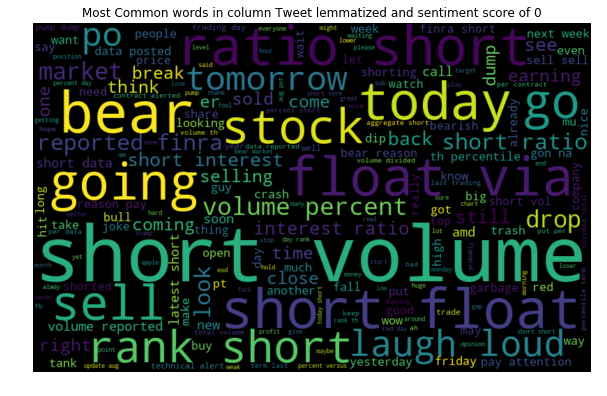

In [41]:
# Below word cloud will say us which word is more important for predicting sentiment score of 0

sentiment_score_0 = ' '.join([text for text in tweets_data['tweet_lemmatized'][tweets_data['sentiment_score'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_0)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 0")
plt.show()

# sell, selling , break , think , drop , dump

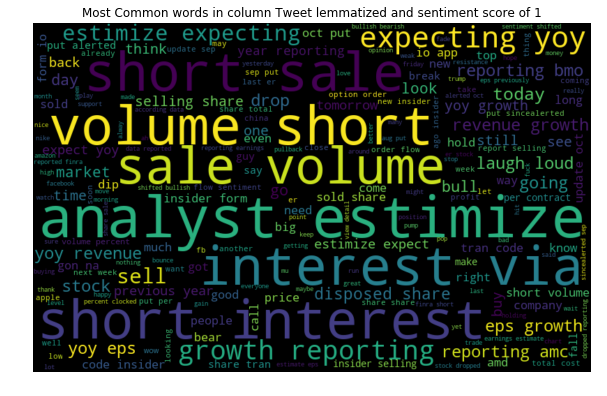

In [42]:
# Below word cloud will say us which word is more important for predicting sentiment score of 1

sentiment_score_1 = ' '.join([text for text in tweets_data['tweet_lemmatized'][tweets_data['sentiment_score'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_1)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 1")
plt.show()

# sell sale , sale , sell

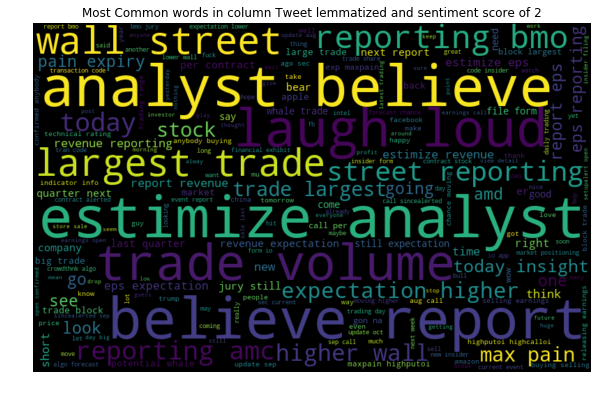

In [43]:
# Below word cloud will say us which word is more important for predicting sentiment score of 2

sentiment_score_2 = ' '.join([text for text in tweets_data['tweet_lemmatized'][tweets_data['sentiment_score'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 2")
plt.show()

# Looks like kind of neutral , no positive nor negative

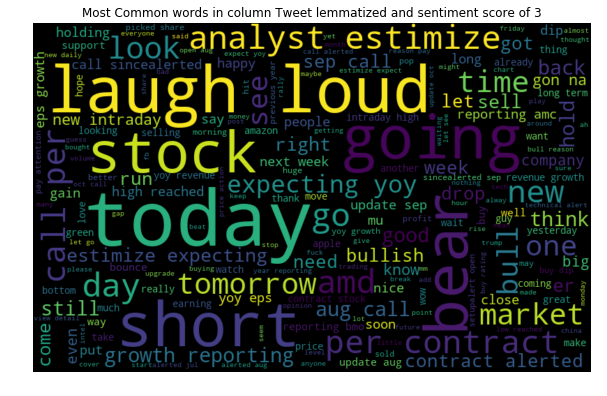

In [44]:
# Below word cloud will say us which word is more important for predicting sentiment score of 3

sentiment_score_3 = ' '.join([text for text in tweets_data['tweet_lemmatized'][tweets_data['sentiment_score'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_3)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 3")
plt.show()

### good, expecting 

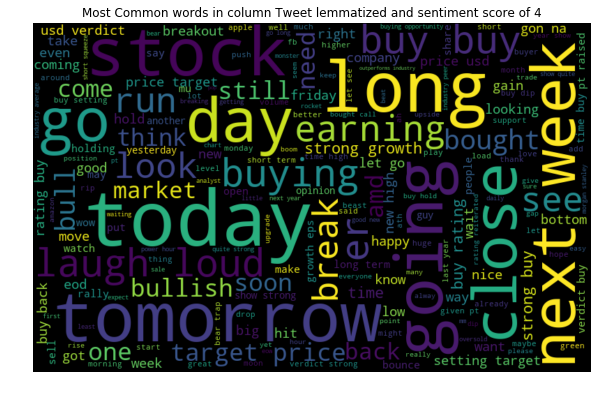

In [45]:
# Below word cloud will say us which word is more important for predicting sentiment score of 4

sentiment_score_4 = ' '.join([text for text in tweets_data['tweet_lemmatized'][tweets_data['sentiment_score'] == 4]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(sentiment_score_4)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in column Tweet lemmatized and sentiment score of 4")
plt.show()

# Earning , Buying , Buy , growth , strong

Number of distinct ticker names in the tweets data :: 2047


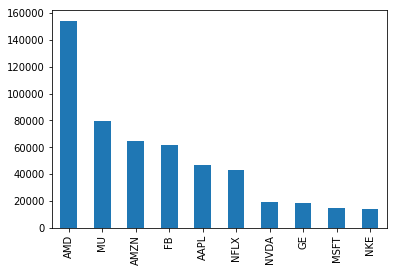

In [46]:
df = tweets_data.ticker.nunique()
print("Number of distinct ticker names in the tweets data ::",df)
ticker_without_dollar = tweets_data['ticker'].apply(lambda x: x.replace("$", ''))
ticker_without_dollar.value_counts().nlargest(10).plot(kind = "bar")

2    413502
3    198994
4    150862
1    117102
0     90310
Name: sentiment_score, dtype: int64

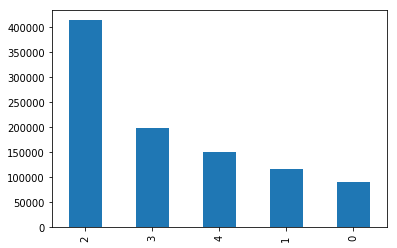

In [47]:
tweets_data['sentiment_score'].value_counts().plot(kind = "bar")
tweets_data['sentiment_score'].value_counts()

In [258]:
### Observation
### For a particular sentiment , WORD CLOUD will say which word is important for predicting that particular sentiment
### Maximum tweets has happened for AMD and MU
### Tweets has maximum of Sentiment score '2'

### Saving the pre-processed text into CSV file 

In [50]:
Pre_process_text = pd.DataFrame(tweets_data)
Pre_process_text.to_csv("Text_preprocessed.csv",index=False)
Pre_process_text.shape

(970770, 8)

## Perform the train test split on the data and then build the model

In [51]:
print(tweets_data['tweet_lemmatized'].shape)
print(tweets_data['sentiment_score'].shape)

(970770,)
(970770,)


In [52]:
x_train, x_validation, y_train, y_validation = train_test_split(tweets_data['tweet_lemmatized'],tweets_data['sentiment_score'],test_size=0.3,random_state=123)

In [53]:
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

(679539,)
(291231,)
(679539,)
(291231,)


### Calculate TF-TDF

In [54]:
# Term Frequency             :- This summarizes how often a given word appears within a document
# Inverse Document Frequency :- This normalizes the affect of words that occur in a large number of documents.
# features as the combination of words provides better significance rather than considering single words as features

In [55]:
Tfidf_vect = TfidfVectorizer(min_df=5,max_df=0.8,ngram_range=(1,3))
Tfidf_vect.fit(x_train)
train_X_Tfidf = Tfidf_vect.transform(x_train)
validation_X_Tfidf = Tfidf_vect.transform(x_validation)

In [259]:
type(train_X_Tfidf)

scipy.sparse.csr.csr_matrix

In [260]:
train_X_Tfidf.shape

(679539, 133176)

## ML Algorithms to Predict the sentiment score

### Naive Bayes model

In [56]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(train_X_Tfidf,y_train)

# predict the sentiment score on train dataset
pred_train_naive = Naive.predict(train_X_Tfidf)

# predict the sentiment score on validation dataset
pred_validation_naive = Naive.predict(validation_X_Tfidf)

# Use accuracy_score function to get the accuracy
print("Sentiment score :: Naive Bayes :: Accuracy Score on Train set -> ", accuracy_score(y_train, pred_train_naive)*100)
print("Sentiment score :: Naive Bayes :: Accuracy Score on Validation set -> ", accuracy_score(y_validation, pred_validation_naive)*100)

print("Sentiment score :: Naive Bayes :: F1 score for train set -->",f1_score(y_train, pred_train_naive,average='macro'))
print("Sentiment score :: Naive Bayes :: F1 score for Validation set -->",f1_score(y_validation, pred_validation_naive,average='macro'))

Sentiment score :: Naive Bayes :: Accuracy Score on Train set ->  65.94117482587461
Sentiment score :: Naive Bayes :: Accuracy Score on Validation set ->  60.61889015935803
Sentiment score :: Naive Bayes :: F1 score for train set --> 0.5984340498097891
Sentiment score :: Naive Bayes :: F1 score for Validation set --> 0.5363789084797906


### Logistic regression model

In [57]:
#logisticreg = LogisticRegression(solver='newton-cg',C=0.9)
logisticreg = LogisticRegression(C=0.9)

In [58]:
logisticreg.fit(train_X_Tfidf,y_train)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
# predict the sentiment score on train dataset
pred_train_log = logisticreg.predict(train_X_Tfidf)

# predict the sentiment score on validation dataset
pred_val_log = logisticreg.predict(validation_X_Tfidf)

In [60]:
# Use accuracy_score function to get the accuracy
print("Sentiment score :: Logistic :: Accuracy Score on Train set -> ", accuracy_score(y_train, pred_train_log)*100)
print("Sentiment score :: Logistic :: Accuracy Score on Validation set -> ", accuracy_score(y_validation, pred_val_log)*100)

print("Sentiment score :: Logistic :: F1 score for train set -->",f1_score(y_train, pred_train_log,average='macro'))
print("Sentiment score :: Logistic :: F1 score for Validation set -->",f1_score(y_validation, pred_val_log,average='macro'))

Sentiment score :: Logistic :: Accuracy Score on Train set ->  69.32376213874406
Sentiment score :: Logistic :: Accuracy Score on Validation set ->  65.20803073848595
Sentiment score :: Logistic :: F1 score for train set --> 0.6448287768367845
Sentiment score :: Logistic :: F1 score for Validation set --> 0.5953078827072615




# Predicting the alpha signal  

# **Logistic Regression

#### Pre-processing of stock factors data

In [102]:
data = pd.read_csv("train_factors-1573207730757.csv")  # Readng CSV which has stock factors SF1 to SF7

In [103]:
data.shape

(27006, 11)

In [104]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [105]:
data["alpha"] = data["alpha"].astype("category")   # Converting Alpha[Y variable] to categorical type
data.dtypes 

Id           int64
date        object
ticker      object
SF1        float64
SF2        float64
SF3        float64
SF4        float64
SF5        float64
SF6        float64
SF7        float64
alpha     category
dtype: object

### Visualization & EDA

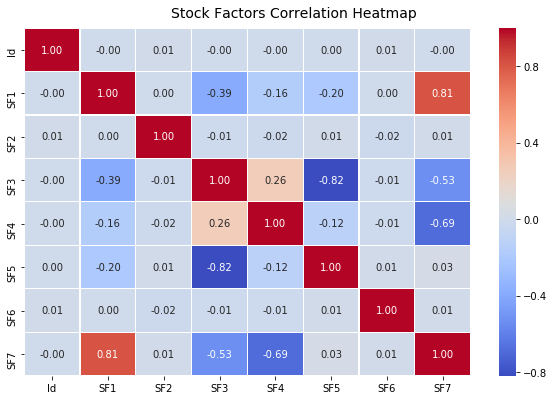

In [106]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Stock Factors Correlation Heatmap', fontsize=14)

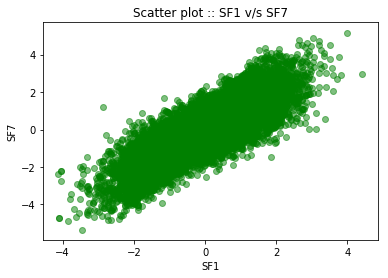

In [107]:
# Plot of SF1 v/s SF7
plt.scatter(data['SF1'], data['SF7'], c='green',alpha=0.5)
plt.title('Scatter plot :: SF1 v/s SF7')
plt.xlabel('SF1')
plt.ylabel('SF7')
plt.show()

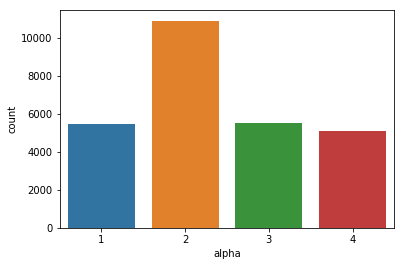

2    10912
3     5536
1     5467
4     5091
Name: alpha, dtype: int64

In [108]:
sns.countplot(x="alpha", data=data)
plt.show()

data.alpha.value_counts()

In [261]:
## Observation
### SF5 and SF3 hasd strong negative linear relationship
### SF1 and SF7 hasd strong positive linear relationship
### Count of Alpha '2' is more 

#### Traina and test split

In [109]:
y_without_sent = data["alpha"]
x_without_sent = data.drop(["alpha","Id","date","ticker"], axis = 1)

x_train_n, x_val_n, y_train_n, y_val_n = train_test_split(x_without_sent, y_without_sent, test_size = 0.3, random_state = 123)

In [110]:
x_train_n.shape

(18904, 7)

In [111]:
y_train_n.dtypes

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False)

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler
scaler.fit(x_train_n)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [113]:
x_train_n=scaler.transform(x_train_n)
x_validation_n=scaler.transform(x_val_n)

## Logistic regression - without sentiment score

In [114]:
# BUild a logistic model
logreg = LogisticRegression()

In [115]:
logreg.fit(x_train_n, y_train_n)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [116]:
#np.round(logreg.coef_,decimals=0) > 0
logreg.coef_

array([[-0.03536556, -0.01183686,  0.17877967, -0.21957843, -0.18665479,
        -0.00099681,  0.07502881],
       [-0.07643418, -0.00590072, -0.11429233, -0.16507322,  0.15801525,
        -0.02554118,  0.05275076],
       [ 0.05911684, -0.00041572,  0.11520101,  0.17822743, -0.1475454 ,
        -0.0039826 , -0.07193715],
       [ 0.09217408,  0.02206522, -0.14605305,  0.30443639,  0.12283261,
         0.04288022, -0.08700467]])

In [117]:
train_pred_n_log = logreg.predict(x_train_n)
val_pred_n_log = logreg.predict(x_validation_n)

In [118]:
print(confusion_matrix(y_true=y_train_n, y_pred = train_pred_n_log))

confusion_matrix_test = confusion_matrix(y_true=y_val_n, y_pred = val_pred_n_log)
confusion_matrix_test

[[ 440 3146  253   34]
 [   5 7337  176   69]
 [  52 3212  525   90]
 [  65 3014  470   16]]


array([[ 161, 1291,  130,   12],
       [   1, 3203,   84,   37],
       [  20, 1366,  237,   34],
       [  33, 1291,  196,    6]], dtype=int64)

In [119]:
print("Alpha score without sentiment:: Logistic :: Accuracy Score on Train set -> ", accuracy_score(y_train_n, train_pred_n_log)*100)
print("Alpha score without sentiment:: Logistic :: Accuracy Score on validation set -> ", accuracy_score(y_val_n, val_pred_n_log)*100)

print("Alpha score without sentiment:: Logistic :: F1 Score on Train set ->",f1_score(y_train_n, train_pred_n_log,average='macro'))
print("Alpha score without sentiment:: Logistic :: F1 Score on Validation set ->",f1_score(y_val_n, val_pred_n_log,average='macro'))

Alpha score without sentiment:: Logistic :: Accuracy Score on Train set ->  44.001269572577236
Alpha score without sentiment:: Logistic :: Accuracy Score on validation set ->  44.51987163663293
Alpha score without sentiment:: Logistic :: F1 Score on Train set -> 0.2522173940122938
Alpha score without sentiment:: Logistic :: F1 Score on Validation set -> 0.25066283446898785


### Feature importance - Without sentiment score

In [120]:
from sklearn.feature_selection import RFE
predictors = x_train_n
selector = RFE(logreg,n_features_to_select=1)
selector = selector.fit(predictors,y_train_n)
ranked = selector.ranking_
print(ranked)

[5 7 3 2 1 6 4]


In [121]:
ranked_new = pd.DataFrame()
ranked_new['Feature_importance']=ranked
ranked_new['feature']=x_without_sent.columns
rank_test = ranked_new.sort_values('Feature_importance')
print(rank_test.to_string(index=False))

 Feature_importance feature
                  1     SF5
                  2     SF4
                  3     SF3
                  4     SF7
                  5     SF1
                  6     SF6
                  7     SF2


In [267]:
#### Obserbvation
#### SF5 and SF4 explains the maximum variation in dependent variable

## Logistic Regression - With sentiment score

#### Pre-Processing :- Here we have to merge the sentiment score we got from twitter data and stock factors from Third party vendors
#### Goal is to merge the data based on date and ticker ID and find the alpha with and without sentiment score. And check the improvement

In [122]:
data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [123]:
data_sf = pd.DataFrame(data)

In [124]:
data_sf.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [125]:
sentiment_data= pd.DataFrame(tweets_data, columns = ['sentiment_score','ticker','timestamp']) 

In [126]:
sentiment_data.sentiment_score.value_counts()

2    413502
3    198994
4    150862
1    117102
0     90310
Name: sentiment_score, dtype: int64

In [127]:
sentiment_data.rename(columns={'timestamp':'date'}, inplace=True)

In [128]:
sentiment_data.shape

(970770, 3)

In [129]:
sentiment_data.head()

,sentiment_score,ticker,date
0,3,$AMD,2018-09-19
1,3,$CAT,2018-10-09
2,2,$AVGO,2018-07-12
3,2,$PH,2018-07-19
4,3,$FB,2018-08-23


In [130]:
import datetime

In [131]:
def change_date_format(date):    
    date = datetime.datetime.strptime(date, '%d/%m/%y').strftime('20%y-%m-%d')
    return date

In [132]:
data_sf['date'] = data_sf['date'].apply(lambda x: change_date_format(x))

### For the given stock and on a given day we can have multiple rows. So grouping them and taking the first row to merge with stock factor data

In [133]:
grouped_data = sentiment_data.groupby(by=['date','ticker'])['sentiment_score'].apply(lambda x:x.value_counts().index[0]).to_frame()

In [134]:
print(grouped_data.shape)

(61368, 1)


In [135]:
grouped_data.sentiment_score.value_counts()

2    39503
3     8032
4     6943
1     4685
0     2205
Name: sentiment_score, dtype: int64

### Merging the grouped sentiment data and stock data based on date and ticker ID

In [136]:
train_data = pd.merge(data_sf, grouped_data, how='left', right_on=['date','ticker'],left_on=['date','ticker'])
train_data.shape

(27006, 12)

In [137]:
train_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,sentiment_score
0,1,2018-08-21,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,2.0
1,2,2018-10-11,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,2.0
2,3,2018-08-21,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,2.0
3,4,2018-07-10,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,NaN
4,5,2018-09-12,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,0.0


In [138]:
train_data['sentiment_score'] = train_data['sentiment_score'].astype('category')

In [139]:
train_data.sentiment_score.value_counts()

2.0    16072
3.0     2763
4.0     2501
1.0     1401
0.0      575
Name: sentiment_score, dtype: int64

In [140]:
train_data.dtypes

Id                    int64
date                 object
ticker               object
SF1                 float64
SF2                 float64
SF3                 float64
SF4                 float64
SF5                 float64
SF6                 float64
SF7                 float64
alpha              category
sentiment_score    category
dtype: object

#### Dropping columns which wont add value for prediction

In [141]:
train_data.drop(["Id","date","ticker"],axis=1,inplace=True)

In [142]:
train_data.isnull().sum()

SF1                   0
SF2                   0
SF3                   0
SF4                   0
SF5                   0
SF6                   0
SF7                   0
alpha                 0
sentiment_score    3694
dtype: int64

#### Split Numeric and Categorical Columns

In [143]:
cat_attr = list(train_data.select_dtypes("category").columns)
num_attr = list(train_data.columns.difference(cat_attr))

cat_attr.remove('alpha')

print("Categorical columns are::",cat_attr)
print("Numerical columns are::",num_attr)


Categorical columns are:: ['sentiment_score']
Numerical columns are:: ['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7']


#### Instantiate Pre-processing Objects for Pipeline

In [144]:
# OneHotEncoder - dummification in skilearn package
# handle_unknown='ignore' ---> if new level comes , ignore that level 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

## Logistic Regression - With Sentiment Score

#### Instantiate Pipeline Object

In [145]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

### Train - Test split

In [146]:
y = train_data["alpha"]
x = train_data.drop(["alpha"], axis = 1)

x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x, y, test_size = 0.3, random_state = 123)

In [147]:
print(x_train_s.shape)
print(y_train_s.shape)

(18904, 8)
(18904,)


In [148]:
clf_logreg.fit(x_train_s, y_train_s)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [149]:
y_pred_train_log = clf_logreg.predict(x_train_s)
y_pred_val_log = clf_logreg.predict(x_val_s)

In [150]:
print("Train :: ",confusion_matrix(y_true=y_train_s, y_pred = y_pred_train_log))

print("Test  ::",confusion_matrix(y_true=y_val_s, y_pred =  y_pred_val_log))


Train ::  [[ 635 2898  240  100]
 [ 266 6956  184  181]
 [ 121 3052  516  190]
 [ 153 2807  447  158]]
Test  :: [[ 238 1178  135   43]
 [ 102 3051   81   91]
 [  63 1286  226   82]
 [  63 1213  189   61]]


In [151]:
print("Alpha score with sentiment:: Logistic :: Accuracy Score on Train set -> ", accuracy_score(y_train_s, y_pred_train_log)*100)
print("Alpha score with sentiment:: Logistic :: Accuracy Score on Train set -> ", accuracy_score(y_val_s, y_pred_val_log)*100)

print("Alpha score with sentiment:: Logistic :: F1 Score on Train set       -> ", f1_score(y_train_s, y_pred_train_log,average='macro'))
print("Alpha score with sentiment:: Logistic :: F1 Score on Train set       -> ", f1_score(y_val_s, y_pred_val_log,average='macro'))

Alpha score with sentiment:: Logistic :: Accuracy Score on Train set ->  43.72090562843843
Alpha score with sentiment:: Logistic :: Accuracy Score on Train set ->  44.137250061713154
Alpha score with sentiment:: Logistic :: F1 Score on Train set       ->  0.27999655926560557
Alpha score with sentiment:: Logistic :: F1 Score on Train set       ->  0.27581710041071134


### Learning curve for logistic regression

In [152]:
## Function to plot the Learning Curve

def plot_Learning_curve(Model_name,classfier,X,y):
    
    # fit
    classfier.fit(X, y)
        
    train_sizes, train_scores, test_scores = learning_curve(classfier, X, y, n_jobs=-1, cv=2, train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(Model_name)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    # box-like grid
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-.1,1.1)
    plt.show()

No handles with labels found to put in legend.


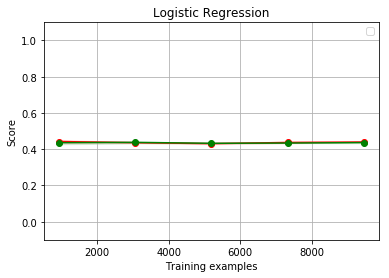

In [153]:
## Calling the function to get the Learning curve
plot_Learning_curve("Logistic Regression",clf_logreg,x_train_s,y_train_s)

In [262]:
# Observation
# Train and Test data is moving together. Its a good sign but accuracy is very less, So trying other models

# **Decision Tree

### Decision Tree - Without Sentiment Score

In [154]:
Dtree_n = DecisionTreeClassifier()

In [155]:
dt_param_grid_n = { "criterion": ["gini", "entropy"],
                  "min_samples_split": [5, 10, 15],
                  "max_depth": [None, 2, 5, 10],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [None, 5, 10, 20]
                }

Dectree_grid_n = GridSearchCV(Dtree_n, param_grid=dt_param_grid_n, cv=3)

In [156]:
%%time
Dectree_grid_n.fit(x_train_n,y_train_n)

Wall time: 1min 18s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 5, 10],
                     

In [157]:
Dectree_grid_n.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_leaf_nodes': None,
 'min_samples_leaf': 5,
 'min_samples_split': 15}

In [158]:
train_pred_n_dt = Dectree_grid_n.predict(x_train_n)
val_pred_n_dt = Dectree_grid_n.predict(x_validation_n)

In [159]:
print("Alpha score without sentiment:: Dec Tree :: Accuracy Score on Train set ->", accuracy_score(y_train_n, train_pred_n_dt)*100)
print("Alpha score without sentiment:: Dec Tree :: Accuracy Score on Train set ->", accuracy_score(y_val_n, val_pred_n_dt)*100)

print("Alpha score without sentiment:: Dec Tree :: F1 Score on Train set       ->", f1_score(y_train_n, train_pred_n_dt,average='macro'))
print("Alpha score without sentiment:: Dec Tree :: F1 Score on Train set       ->", f1_score(y_val_n, val_pred_n_dt,average='macro'))

Alpha score without sentiment:: Dec Tree :: Accuracy Score on Train set -> 72.04295387219636
Alpha score without sentiment:: Dec Tree :: Accuracy Score on Train set -> 65.02098247346333
Alpha score without sentiment:: Dec Tree :: F1 Score on Train set       -> 0.6779161382504308
Alpha score without sentiment:: Dec Tree :: F1 Score on Train set       -> 0.5842876012140076


### Decision Tree - With Sentiment Score

In [160]:
clf_DTree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Dectree', DecisionTreeClassifier())])

In [161]:
dt_param_grid = {"Dectree__criterion": ["gini", "entropy"],
              "Dectree__min_samples_split": [5, 10, 15],
              "Dectree__max_depth": [None, 2, 5, 10],
              "Dectree__min_samples_leaf": [1, 5, 10],
              "Dectree__max_leaf_nodes": [None, 5, 10, 20]
              }

Dectree_grid = GridSearchCV(clf_DTree, param_grid=dt_param_grid, cv=3)

In [162]:
%%time
Dectree_grid.fit(x_train_s, y_train_s)

Wall time: 1min 53s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [163]:
Dectree_grid.best_params_

{'Dectree__criterion': 'entropy',
 'Dectree__max_depth': 10,
 'Dectree__max_leaf_nodes': None,
 'Dectree__min_samples_leaf': 5,
 'Dectree__min_samples_split': 15}

In [164]:
y_pred_train_dct = Dectree_grid.predict(x_train_s)
y_pred_val_dct = Dectree_grid.predict(x_val_s)

In [165]:
print("Alpha score with sentiment:: Dec Tree :: Accuracy Score on Train set      -> ", accuracy_score(y_train_s, y_pred_train_dct)*100)
print("Alpha score with sentiment:: Dec Tree :: Accuracy Score on Validation set -> ", accuracy_score(y_val_s, y_pred_val_dct)*100)

print("Alpha score with sentiment:: Dec Tree :: F1 Score on Train set            -> ", f1_score(y_train_s, y_pred_train_dct,average='macro'))
print("Alpha score with sentiment:: Dec Tree :: F1 Score on Validation set       -> ", f1_score(y_val_s, y_pred_val_dct,average='macro'))

Alpha score with sentiment:: Dec Tree :: Accuracy Score on Train set      ->  72.00063478628861
Alpha score with sentiment:: Dec Tree :: Accuracy Score on Validation set ->  65.02098247346333
Alpha score with sentiment:: Dec Tree :: F1 Score on Train set            ->  0.6772829249804168
Alpha score with sentiment:: Dec Tree :: F1 Score on Validation set       ->  0.5847876833720917


### Decision Tree  - Feature importance 

In [172]:
new_column_list = list(x_train_s.columns)
new_column_list.remove('sentiment_score')
new_column_list.append('Sentiment_score_0')
new_column_list.append('Sentiment_score_1')
new_column_list.append('Sentiment_score_2')
new_column_list.append('Sentiment_score_3')
new_column_list.append('Sentiment_score_4')
Features_dummified = np.array(new_column_list)
print(Features_dummified)
type(Features_dummified)

['SF1' 'SF2' 'SF3' 'SF4' 'SF5' 'SF6' 'SF7' 'Sentiment_score_0'
 'Sentiment_score_1' 'Sentiment_score_2' 'Sentiment_score_3'
 'Sentiment_score_4']


numpy.ndarray

In [173]:
Dectree_grid.best_estimator_.named_steps["Dectree"].feature_importances_

array([2.23766976e-01, 1.81103011e-02, 2.82151787e-01, 3.03322690e-01,
       1.14818131e-01, 1.48788841e-02, 4.00046885e-02, 0.00000000e+00,
       1.89512654e-03, 8.53781447e-04, 0.00000000e+00, 1.97634833e-04])

In [174]:
importances = Dectree_grid.best_estimator_.named_steps["Dectree"].feature_importances_
indices = np.argsort(importances)
print(indices)

[ 7 10 11  9  8  5  1  6  4  0  2  3]


In [175]:
indices1 = np.argsort(importances)[::-1]
indices_hl = np.sort(importances)[::-1]
print(indices1)
pd.DataFrame([Features_dummified[indices1],indices_hl])

[ 3  2  0  4  6  1  5  8  9 11 10  7]


,0,1,2,3,4,5,6,7,8,9,10,11
0,SF4,SF3,SF1,SF5,SF7,SF2,SF6,Sentiment_score_1,Sentiment_score_2,Sentiment_score_4,Sentiment_score_3,Sentiment_score_0
1,0.303323,0.282152,0.223767,0.114818,0.0400047,0.0181103,0.0148789,0.00189513,0.000853781,0.000197635,0,0


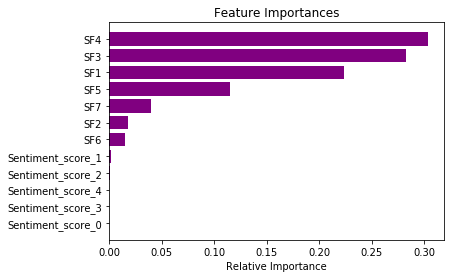

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline
features = Features_dummified

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='purple')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Observation
# Above plot tells us why there is NO change in accuracy even after including the sentiment score
# Sentiment scores are contriibuting nearly ZERO for prediction

### Learning curve - Decision Trees

No handles with labels found to put in legend.


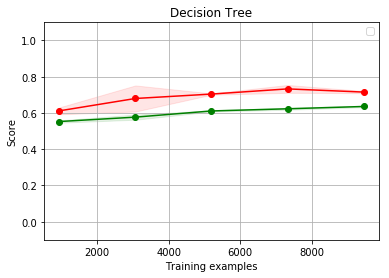

In [177]:
plot_Learning_curve("Decision Tree",Dectree_grid,x_train_s,y_train_s)

In [264]:
### Observation
### Train accuracy is higher than validation.  As data size increases, the train and validation accuracy will be in sync[Its a sign of Overfit]
## Accuracy is better than Logistic Regression, its in the range of 70%. 

# **Random forest

### Random Forest - Without Sentiment Score

In [178]:
Ran_forest_n = RandomForestClassifier()

In [179]:
randfor_param_grid_n = {
                        'bootstrap': [True],
                        'max_depth': [7,8],
                        'max_features': ['auto','sqrt'],
                        'min_samples_leaf': [3,4],
                        'min_samples_split': [8, 10],
                        'n_estimators': [150,200]
                    }

rand_frst_grid_n = GridSearchCV(Ran_forest_n, param_grid=randfor_param_grid_n, cv=2)

In [180]:
%%time
rand_frst_grid_n.fit(x_train_n,y_train_n)

Wall time: 2min 58s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [181]:
rand_frst_grid_n.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [182]:
train_pred_n_rf = rand_frst_grid_n.predict(x_train_n)
val_pred_n_rf   = rand_frst_grid_n.predict(x_validation_n)

In [183]:
print("Alpha score without sentiment:: RF :: Accuracy Score on Train set ->", accuracy_score(y_train_n, train_pred_n_rf)*100)
print("Alpha score without sentiment:: RF :: Accuracy Score on Train set ->", accuracy_score(y_val_n, val_pred_n_rf)*100)

print("Alpha score without sentiment:: RF :: F1 Score on Train set       ->", f1_score(y_train_n, train_pred_n_rf,average='macro'))
print("Alpha score without sentiment:: RF :: F1 Score on Train set       ->", f1_score(y_val_n, val_pred_n_rf,average='macro'))

Alpha score without sentiment:: RF :: Accuracy Score on Train set -> 68.35590351248413
Alpha score without sentiment:: RF :: Accuracy Score on Train set -> 65.05801036781041
Alpha score without sentiment:: RF :: F1 Score on Train set       -> 0.6336398142225546
Alpha score without sentiment:: RF :: F1 Score on Train set       -> 0.5820927261263831


### Random Forest - With Sentiment Score

In [184]:
clf_randfor = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rand_forest', RandomForestClassifier())])

In [185]:
randfor_param_grid = {
    'rand_forest__bootstrap': [True],
    'rand_forest__max_depth': [7,8],
    'rand_forest__max_features': ['auto','sqrt'],
    'rand_forest__min_samples_leaf': [3,4],
    'rand_forest__min_samples_split': [8, 10],
    'rand_forest__n_estimators': [150,200]
}

rand_frst_grid = GridSearchCV(clf_randfor, param_grid=randfor_param_grid, cv=2)

In [186]:
%%time
rand_frst_grid.fit(x_train_s,y_train_s)

Wall time: 2min 37s


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [187]:
rand_frst_grid.best_params_

{'rand_forest__bootstrap': True,
 'rand_forest__max_depth': 8,
 'rand_forest__max_features': 'auto',
 'rand_forest__min_samples_leaf': 4,
 'rand_forest__min_samples_split': 8,
 'rand_forest__n_estimators': 200}

In [188]:
y_pred_train_rf = rand_frst_grid.predict(x_train_s)
y_pred_val_rf   = rand_frst_grid.predict(x_val_s)

In [189]:
print("Alpha score with sentiment:: RF :: Accuracy Score on Train set      -> ", accuracy_score(y_train_s, y_pred_train_rf)*100)
print("Alpha score with sentiment:: RF :: Accuracy Score on Validation set -> ", accuracy_score(y_val_s, y_pred_val_rf)*100)

print("Alpha score with sentiment:: RF :: F1 Score on Train set            ->",f1_score(y_train_s, y_pred_train_rf,average='macro'))
print("Alpha score with sentiment:: RF :: F1 Score on Validation set       ->",f1_score(y_val_s, y_pred_val_rf,average='macro'))

Alpha score with sentiment:: RF :: Accuracy Score on Train set      ->  67.07046127803639
Alpha score with sentiment:: RF :: Accuracy Score on Validation set ->  64.0088866946433
Alpha score with sentiment:: RF :: F1 Score on Train set            -> 0.6181448754736825
Alpha score with sentiment:: RF :: F1 Score on Validation set       -> 0.5692041909637615


### Random Forest - Feature importance

In [190]:
rand_frst_grid.best_estimator_.named_steps["rand_forest"].feature_importances_

array([0.17191523, 0.01249232, 0.30755752, 0.20292183, 0.17577553,
       0.01296321, 0.09656974, 0.0007141 , 0.00873564, 0.00634369,
       0.00136533, 0.00264587])

In [191]:
importances = rand_frst_grid.best_estimator_.named_steps["rand_forest"].feature_importances_
indices = np.argsort(importances)
print(indices)

[ 7 10 11  9  8  1  5  6  0  4  3  2]


In [192]:
indices1 = np.argsort(importances)[::-1]
indices_hl = np.sort(importances)[::-1]
print(indices1)
pd.DataFrame([Features_dummified[indices1],indices_hl])

[ 2  3  4  0  6  5  1  8  9 11 10  7]


,0,1,2,3,4,5,6,7,8,9,10,11
0,SF3,SF4,SF5,SF1,SF7,SF6,SF2,Sentiment_score_1,Sentiment_score_2,Sentiment_score_4,Sentiment_score_3,Sentiment_score_0
1,0.307558,0.202922,0.175776,0.171915,0.0965697,0.0129632,0.0124923,0.00873564,0.00634369,0.00264587,0.00136533,0.0007141


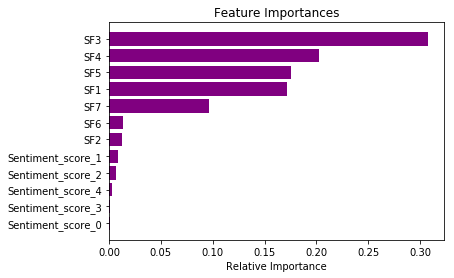

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline
features = Features_dummified

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='purple')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Observation
# Above plot tells us why there is NO change in accuracy even after including the sentiment score
# Sentiment scores are contriibuting very minute for prediction

### Learning Curve - Random Forest

No handles with labels found to put in legend.


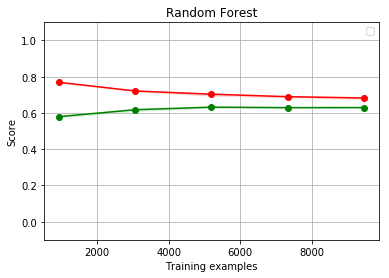

Wall time: 6min 24s


In [194]:
%%time
plot_Learning_curve("Random Forest",rand_frst_grid,x_train_s,y_train_s)

In [265]:
## Observation
## Initially [ with less data], train and validation scores were very different. As size of data increases,
## Accuracy of train and Validation looks same
## Accuracy is better than Logistic Regression but less than decision tree.  Its in the range of 65%

# **XGBoost

### XGBoost - without sentiment score

In [195]:
xg_boost_n = XGBClassifier()

In [196]:
Xgbm_param_grid_n = {'xg_boost_n__max_depth': [4,5], 'xg_boost_n__subsample': [0.8,0.7], 
                  'xg_boost_n_n_estimators': [150,200], 'xg_boost_n__learning_rate ':[0.05,0.04],'xgboost__alpha ':[0.005,0.004] }

Xgbm_grid_n = GridSearchCV(xg_boost_n, param_grid=Xgbm_param_grid_n, cv=3)

In [197]:
%%time
Xgbm_grid_n.fit(x_train_n,y_train_n)

Wall time: 7min 22s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'xg_boost_n__learning_rate ': [0.05, 0.04],
                         'xg_boost_n__max_depth': [4, 5],
                         'xg_boost_n__subsamp

In [198]:
Xgbm_grid_n.best_params_

{'xg_boost_n__learning_rate ': 0.05,
 'xg_boost_n__max_depth': 4,
 'xg_boost_n__subsample': 0.8,
 'xg_boost_n_n_estimators': 150,
 'xgboost__alpha ': 0.005}

In [199]:
train_pred_n_xgb = Xgbm_grid_n.predict(x_train_n)
val_pred_n_xgb = Xgbm_grid_n.predict(x_validation_n)

In [200]:
print("Alpha score without sentiment:: XGBoost :: Accuracy Score on Train set ->", accuracy_score(y_train_n, train_pred_n_xgb)*100)
print("Alpha score without sentiment:: XGBoost :: Accuracy Score on Train set ->", accuracy_score(y_val_n, val_pred_n_xgb)*100)

print("Alpha score without sentiment:: XGBoost :: F1 Score on Train set       ->",f1_score(y_train_n, train_pred_n_xgb,average='macro'))
print("Alpha score without sentiment:: XGBoost :: F1 Score on Train set       ->",f1_score(y_val_n, val_pred_n_xgb,average='macro'))

Alpha score without sentiment:: XGBoost :: Accuracy Score on Train set -> 65.63161235717308
Alpha score without sentiment:: XGBoost :: Accuracy Score on Train set -> 63.62626511972353
Alpha score without sentiment:: XGBoost :: F1 Score on Train set       -> 0.596546936120942
Alpha score without sentiment:: XGBoost :: F1 Score on Train set       -> 0.5648030983169328


### XGBoost - With Sentiment Score

In [201]:
clf_XGBoost = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgboost', XGBClassifier())])

In [202]:
Xgbm_param_grid = {'xgboost__max_depth': [3,4], 'xgboost__subsample': [0.8], 
                  'xgboost__n_estimators': [150,200], 'xgboost__learning_rate ':[0.04,0.05],'xgboost__alpha ':[0.004,0.005],
                  'xgboost__min_child_weight': [4,5], 'xgboost__gamma ':[0.1]}

Xgbm_grid = GridSearchCV(clf_XGBoost, param_grid=Xgbm_param_grid, cv=3)

In [203]:
%%time
Xgbm_grid.fit(x_train_s, y_train_s)

Wall time: 18min 12s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [204]:
Xgbm_grid.best_params_

{'xgboost__alpha ': 0.004,
 'xgboost__gamma ': 0.1,
 'xgboost__learning_rate ': 0.04,
 'xgboost__max_depth': 4,
 'xgboost__min_child_weight': 5,
 'xgboost__n_estimators': 200,
 'xgboost__subsample': 0.8}

In [205]:
y_pred_train_xgb = Xgbm_grid.predict(x_train_s)
y_pred_val_xgb = Xgbm_grid.predict(x_val_s)

In [206]:
print("Alpha score with sentiment:: XGBoost :: Accuracy Score on Train set      -> ", accuracy_score(y_train_s, y_pred_train_xgb)*100)
print("Alpha score with sentiment:: XGBoost :: Accuracy Score on Validation set -> ", accuracy_score(y_val_s, y_pred_val_xgb)*100)

print("Alpha score with sentiment:: XGBoost :: F1 Score on Train set            -> ", f1_score(y_train_s, y_pred_train_xgb,average='macro'))
print("Alpha score with sentiment:: XGBoost :: F1 Score on Validation set       -> ", f1_score(y_val_s, y_pred_val_xgb,average='macro'))

Alpha score with sentiment:: XGBoost :: Accuracy Score on Train set      ->  72.40266610241218
Alpha score with sentiment:: XGBoost :: Accuracy Score on Validation set ->  68.18069612441371
Alpha score with sentiment:: XGBoost :: F1 Score on Train set            ->  0.6805946800386614
Alpha score with sentiment:: XGBoost :: F1 Score on Validation set       ->  0.6211671298562871


## XGBoost - Feature importance - With sentiment score

In [207]:
#Xgbm_grid.steps[1][1].feature_importances_
Xgbm_grid.best_estimator_.named_steps["xgboost"].feature_importances_

array([0.09127024, 0.02301117, 0.18951057, 0.14976145, 0.08782478,
       0.02363455, 0.05952157, 0.04831864, 0.13885486, 0.0758481 ,
       0.02818325, 0.08426086], dtype=float32)

In [208]:
importances = Xgbm_grid.best_estimator_.named_steps["xgboost"].feature_importances_
indices = np.argsort(importances)
print(indices)

[ 1  5 10  7  6  9 11  4  0  8  3  2]


In [209]:
indices1 = np.argsort(importances)[::-1]
indices_hl = np.sort(importances)[::-1]
print(indices1)
pd.DataFrame([Features_dummified[indices1],indices_hl])

[ 2  3  8  0  4 11  9  6  7 10  5  1]


,0,1,2,3,4,5,6,7,8,9,10,11
0,SF3,SF4,Sentiment_score_1,SF1,SF5,Sentiment_score_4,Sentiment_score_2,SF7,Sentiment_score_0,Sentiment_score_3,SF6,SF2
1,0.189511,0.149761,0.138855,0.0912702,0.0878248,0.0842609,0.0758481,0.0595216,0.0483186,0.0281832,0.0236345,0.0230112


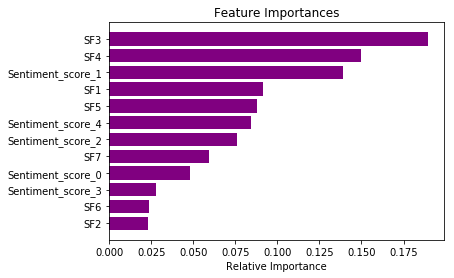

In [210]:
import matplotlib.pyplot as plt
%matplotlib inline
features = Features_dummified

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='purple')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [268]:
# Observation
# In this model , we can see there is a significant contribution of Sentiment score to the prediction, 
# So only we are seeing a increase in the accuracy after including sentiment score

## Learning curve - XGBoost

No handles with labels found to put in legend.


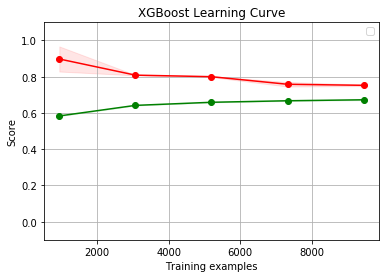

Wall time: 45min 4s


In [211]:
%%time
plot_Learning_curve("XGBoost Learning Curve",Xgbm_grid,x_train_s,y_train_s)

In [ ]:
## Observation
## Train accuracy is higher than Validation and as data increases accuracy is constant
## Accuracy is in range of 70%

# Comparision between performance of different ML models



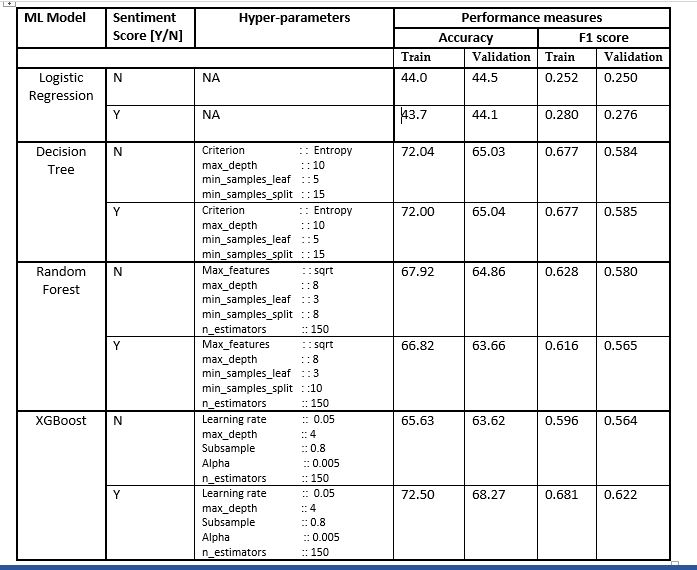

In [212]:
Image("Model_comparision.jpg")

# TEST DATA  FOR PREDICTION OF SENTIMENT SCORE AND ALPHA



### Doing pre-processing for the test twitter data to get the sentiment score

In [213]:
json_test_data = pd.read_json("test_data.json")

In [214]:
json_test_data.head()

,records
0,{'stocktwit_tweet': '$CELG nothing to be exite...
1,{'stocktwit_tweet': '$AMD yall exhaust your bu...
2,"{'stocktwit_tweet': '$AMD day traders day.', '..."
3,{'stocktwit_tweet': '$CBS https://tenor.com/wL...
4,{'stocktwit_tweet': '$MU weak price action so ...


In [215]:
tweets_test_data = pd.DataFrame([md for md in json_test_data.records])
tweets_test_data.head()

,stocktwit_tweet,ticker,timestamp
0,$CELG nothing to be exited about,$CELG,2018-10-25 14:26:16+00:00
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13 13:50:39+00:00
2,$AMD day traders day.,$AMD,2018-09-25 19:10:54+00:00
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27 22:45:48+00:00
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31 14:59:06+00:00


In [216]:
tweets_test_data['timestamp'] = tweets_test_data['timestamp'] .str.split(' ').str[0]

In [217]:
print("Length before duplicates",len(tweets_test_data))
tweets_test_data.drop_duplicates(keep = False, inplace = True) 
print("Length before duplicates",len(tweets_test_data))

Length before duplicates 265022
Length before duplicates 258777


In [218]:
tweets_test_data['clean_tweet'] = tweets_test_data['stocktwit_tweet'].apply(lambda x: html_parser.unescape(x))
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: lookup_dict(x,emoticon_dict))
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: re.sub('http\S*|www.\S*', '', x))
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: remove_pattern(x,"@[\w]*"))
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: re.sub("\$[\w]*","",x))
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: re.sub(r'[^\w\s]',' ',x)) # ReplacingPunctuations with space
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))# Replacing Special Characters with space
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x)) # Replacing Numbers (integers) with space
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: x.lower())
tweets_test_data.head(10)

,stocktwit_tweet,ticker,timestamp,clean_tweet
0,$CELG nothing to be exited about,$CELG,2018-10-25,nothing to be exited about
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13,yall exhaust your buyer on first green candle...
2,$AMD day traders day.,$AMD,2018-09-25,day traders day
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27,
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31,weak price action so far today don t be afra...
5,"$AMZN continues to grow, specifically in key a...",$AMZN,2018-08-04,continues to grow specifically in key areas ...
6,"$CLF If you are not loading up right now, you ...",$CLF,2018-08-17,if you are not loading up right now you are ...
7,$MU crap shoot. Legit no one knows if it’s goi...,$MU,2018-09-21,crap shoot legit no one knows if it s going ...
8,$AMD how does this chart look like a setup for...,$AMD,2018-09-19,how does this chart look like a setup for a d...
9,$AMD amd is like my sex life. Its so dry rn,$AMD,2018-09-21,amd is like my sex life its so dry rn


In [219]:
tweets_test_data.dtypes

stocktwit_tweet    object
ticker             object
timestamp          object
clean_tweet        object
dtype: object

In [220]:
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: lookup_dict(x,contractions))
tweets_test_data['clean_tweet'] = tweets_test_data['clean_tweet'].apply(lambda x: lookup_dict(x,short_word_dict))

In [221]:
tweets_test_data['tweet_token'] = tweets_test_data['clean_tweet'].apply(lambda x: word_tokenize(x))

In [222]:
from nltk.corpus import stopwords 
stopwords = set(stopwords.words('english')) 

#stopwords = spacy.lang.en.stop_words.STOP_WORDS

print('Before Number of stop words: %d' % len(stopwords))
print('First ten stop words: %s' % list(stopwords)[:10])
stopwords.remove('no')
stopwords.remove('not')
stopwords.add("stocktwits")
stopwords.add("source")
stopwords.add("utm")
stopwords.add("historical")

print('After Number of stop words: %d' % len(stopwords))

Before Number of stop words: 179
First ten stop words: ['few', 'through', "couldn't", 'hasn', 'other', 'been', 'or', 'our', "aren't", 'only']
After Number of stop words: 181


In [223]:
tweets_test_data['tweet_token_filtered'] = tweets_test_data['tweet_token'].apply(lambda x: [word for word in x if not word in stopwords])

In [224]:
tweets_test_data['tweet_lemmatized'] = tweets_test_data['tweet_token_filtered'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))

In [225]:
x_test_Tfidf = Tfidf_vect.transform(tweets_test_data['tweet_lemmatized'])

### Predicting the sentiment score on pre-processed test data

In [226]:
pred_test_final = logisticreg.predict(x_test_Tfidf)

In [227]:
print(len(pred_test_final))
print(len(tweets_test_data))

258777
258777


In [228]:
print(type(pred_test_final))
print(type(tweets_test_data))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [229]:
tweets_test_data.head()

,stocktwit_tweet,ticker,timestamp,clean_tweet,tweet_token,tweet_token_filtered,tweet_lemmatized
0,$CELG nothing to be exited about,$CELG,2018-10-25,nothing to be exited about,"[nothing, to, be, exited, about]","[nothing, exited]",nothing exited
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13,yall exhaust your buyer on first green candle...,"[yall, exhaust, your, buyer, on, first, green,...","[yall, exhaust, buyer, first, green, candle, b...",yall exhaust buyer first green candle byeeeeee
2,$AMD day traders day.,$AMD,2018-09-25,day traders day,"[day, traders, day]","[day, traders, day]",day trader day
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27,,[],[],
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31,weak price action so far today don t be afra...,"[weak, price, action, so, far, today, don, t, ...","[weak, price, action, far, today, afraid, go, ...",weak price action far today afraid go short go...


In [230]:
tweets_test_data['sentiment_score'] = pd.DataFrame(pred_test_final)

In [231]:
tweets_test_data.head()

,stocktwit_tweet,ticker,timestamp,clean_tweet,tweet_token,tweet_token_filtered,tweet_lemmatized,sentiment_score
0,$CELG nothing to be exited about,$CELG,2018-10-25,nothing to be exited about,"[nothing, to, be, exited, about]","[nothing, exited]",nothing exited,2.0
1,$AMD yall exhaust your buyer on first green ca...,$AMD,2018-07-13,yall exhaust your buyer on first green candle...,"[yall, exhaust, your, buyer, on, first, green,...","[yall, exhaust, buyer, first, green, candle, b...",yall exhaust buyer first green candle byeeeeee,4.0
2,$AMD day traders day.,$AMD,2018-09-25,day traders day,"[day, traders, day]","[day, traders, day]",day trader day,2.0
3,$CBS https://tenor.com/wLB8.gif,$CBS,2018-07-27,,[],[],,2.0
4,$MU weak price action so far today. Don’t be a...,$MU,2018-07-31,weak price action so far today don t be afra...,"[weak, price, action, so, far, today, don, t, ...","[weak, price, action, far, today, afraid, go, ...",weak price action far today afraid go short go...,0.0


In [232]:
print("Number of rows :Before:", tweets_test_data.shape)
tweets_test_data = tweets_test_data[tweets_test_data['tweet_lemmatized']!=""]
print("Number of rows :After:", tweets_test_data.shape)

Number of rows :Before: (258777, 8)
Number of rows :After: (251799, 8)


In [233]:
tweets_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251799 entries, 0 to 265021
Data columns (total 8 columns):
stocktwit_tweet         251799 non-null object
ticker                  251799 non-null object
timestamp               251799 non-null object
clean_tweet             251799 non-null object
tweet_token             251799 non-null object
tweet_token_filtered    251799 non-null object
tweet_lemmatized        251799 non-null object
sentiment_score         245865 non-null float64
dtypes: float64(1), object(7)
memory usage: 17.3+ MB


# Test data for alpha signal prediction

In [234]:
test_data = pd.read_csv("test_factors.csv")

In [235]:
test_data.shape

(11575, 10)

In [236]:
test_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7
0,270007,21/07/18,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449
1,270008,05/10/18,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353
2,270009,01/10/18,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811
3,270010,24/10/18,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803
4,270011,27/07/18,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111


In [237]:
test_data.dtypes

Id          int64
date       object
ticker     object
SF1       float64
SF2       float64
SF3       float64
SF4       float64
SF5       float64
SF6       float64
SF7       float64
dtype: object

In [238]:
sentiment_test_data= pd.DataFrame(tweets_test_data, columns = ['sentiment_score','ticker','timestamp']) 

In [239]:
sentiment_test_data.head()

,sentiment_score,ticker,timestamp
0,2.0,$CELG,2018-10-25
1,4.0,$AMD,2018-07-13
2,2.0,$AMD,2018-09-25
4,0.0,$MU,2018-07-31
5,2.0,$AMZN,2018-08-04


In [240]:
sentiment_test_data.rename(columns={'timestamp':'date'}, inplace=True)

In [241]:
test_data['date'] = test_data['date'].apply(lambda x: change_date_format(x))

In [242]:
sentiment_test_data.isnull().sum()

sentiment_score    5934
ticker                0
date                  0
dtype: int64

In [243]:
sentiment_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251799 entries, 0 to 265021
Data columns (total 3 columns):
sentiment_score    245865 non-null float64
ticker             251799 non-null object
date               251799 non-null object
dtypes: float64(1), object(2)
memory usage: 7.7+ MB


In [244]:
sentiment_test_data['sentiment_score'] = sentiment_test_data['sentiment_score'].astype('category')

In [245]:
grouped_test_data = sentiment_test_data.groupby(by=['date','ticker'])['sentiment_score'].apply(lambda x:x.value_counts().index[0]).to_frame()

In [246]:
test_merged_data = pd.merge(test_data, grouped_test_data, how='left', right_on=['date','ticker'],left_on=['date','ticker'])
test_merged_data.shape

(11575, 11)

In [247]:
test_merged_data.head()

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,sentiment_score
0,270007,2018-07-21,$INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,3.0
1,270008,2018-10-05,$CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,4.0
2,270009,2018-10-01,$CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,4.0
3,270010,2018-10-24,$CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,4.0
4,270011,2018-07-27,$intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,2.0


In [248]:
test_merged_data.sentiment_score.value_counts()

2.0    6828
4.0    1902
3.0    1653
1.0     482
0.0     400
Name: sentiment_score, dtype: int64

In [249]:
test_merged_data.isnull().sum()

Id                   0
date                 0
ticker               0
SF1                  0
SF2                  0
SF3                  0
SF4                  0
SF5                  0
SF6                  0
SF7                  0
sentiment_score    310
dtype: int64

In [250]:
test_merged_data = test_merged_data.drop(["Id","date","ticker"], axis = 1)

In [251]:
num_test_cols = ["SF1","SF2","SF3","SF4","SF5","SF6","SF7"]
cat_test_cols = ["sentiment_score"]

In [252]:
test_merged_data["sentiment_score"] = test_merged_data["sentiment_score"].astype('category')

In [253]:
test_merged_data.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,sentiment_score
0,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,3.0
1,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,4.0
2,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,4.0
3,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,4.0
4,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,2.0


In [254]:
test_merged_data.isnull().sum()

SF1                  0
SF2                  0
SF3                  0
SF4                  0
SF5                  0
SF6                  0
SF7                  0
sentiment_score    310
dtype: int64

### Sample CSV file generation

In [255]:
df = pd.read_csv("sample_submission-1573207831967.csv")

In [256]:
test_final_pred = Xgbm_grid.predict(test_merged_data)

new_df = pd.DataFrame(list(zip(df['id'],test_final_pred)),columns=['id','alpha'])
new_df.to_csv("xg_boost_sub_final1.csv",index=False)
new_df.shape

(11575, 2)